In [2]:
# Import packages for calculation and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
# Time package for performance measurements
import time
# Pandas for convenient table export
import pandas as pd
# Settings for seaborn plots
sns.set()
sns.set_context("paper")
sns.set_style("whitegrid")

# Analysis of braking behviour in shunting
Shunting brake instructions differ widely from mainline in that according to 

- DB guideline 915, up to 40 wheelsets
- BAV R 300.4, up to 5 times the mass of the locomotive

can be shunted without continuous air brake, depending on gradient.

***

## Function definitions

### Instantaneous friction coefficient acc. to Karwatzki

Especially at low velocities, the variation in brake block friction are high and have to be accounted for. Karwatzki formula can be used to approximate instantaneous friction coefficients.

$$\mu(F_{block}, v) = k_1 \left(\frac{F_{block} + k_2}{F_{block} + k_3} \right)\left(\frac{v + k_4}{v + k_5} \right)$$

In [3]:
# Friction value function according to Karwatzki formula
def muBr(v,F):
    # Karwatzki parameter (composite blocks)
    k1 = 0.055
    k2 = 200000 #N
    k3 = 50000 #N
    k4 = 150/3.6 #m/s
    k5 = 75/3.6 #m/s
    return k1 * (F+k2)/(F+k3) * (v+k4)/(v+k5)

### Braking Calculation for shunting cases

#### Parameters

The function applies the following parameters:

- $d_t$: time step for discretisation in *s*
- $c$: Propagation velocity in brake pipe in *m/s*

#### Input data

The function accepts a dictionary with the following fields:

- $v_0$: Initial velocity
- Locomotive data:

    - $m_{Loco}$: Mass
    - $F_{Loco}$: Braking force
    - $l_{Loco}$: Length
    - $tf_{Loco}$: Loco filling time
    - $G_{Loco}$: True if brake mode of locomotive is set to G

- $m$: Mass of individual wagons in *kg*
- $m_{rot}$: Dynamic augment on wagon mass for rotating masses
- $G$: True if brake mode of individual wagon is set to G
- $C_{dia}$: Cylinder diameter in *m*
- $p$: Brake cylinder pressure in *Pa*
- $l$: Wagons length in *m*
- $i$: Brake rigging ratio
- $\eta$: Brake rigging efficiency
- $t_f$: Filling time in *s*
- $n$:  Number of brake blocks
- $\mu_C$: Correction factor for friction variation

All fields accept lists as input to express the individual wagons in the train set  

#### Operation

1. Initialise data
1. According to position in the train, the filling time is increased to express the delay by the propagation
1. While the simulation yields a velocity above 0:

    - For each wagon, calculate the brake cylinder force Fc
    - While within filling time, calculate cylinder force proportion acc. to:
   
        * if in brake mode G, immediately apply 10% of the brake cylinder pressure
        * linearly increase pressure depending on time
    
    - Calculate block force
    - Calculate instantaneous friction coefficient acc. to Karwatzki
    - Calculate resistance acc. to Strahl
    - Update velocity and distance
  
1. Return braking distance
    
    

In [4]:
def ShuntingBrakeCalculation(data):
    c = 250 # brake propagation velocity
    #FL = FLoco #Loco braking force
    dt = 0.05
    s = 0
    t = 0
    # Import data from input
    v = data['v0']
    mloco = data['mloco']
    Floco = data['Floco']
    lloco = data['lloco']
    tfloco = data['tfloco']
    gloco = data['Gloco']
    m = data['m']
    mrot = data['mrot']
    tf = data['tf']
    gmode = data['G']
    cdia = data['Cdia']
    p = data['p']
    l = data['l']
    i = data['i']
    n = data['n']
    eta = data['eta']
    muc = data['muc']
    # Correct filling time according to position in train
    for k in range(len(l)):
        tf[k] = tf[k] + (lloco + np.sum(l[0:k]))/c
    
    while v > 0:
        F = [] # List for vehicle Forces
        # Treat locomotive
        if t < tfloco: # Respect filling time
                # 10% immediate pressure in brake mode G
            if bool(gloco):
                fill = 0.1+0.9*(t/tfloco)
            else: # Linear behaivour in P
                fill = t/tfloco
        else:
            fill = 1 #Fully filled after tf
        F.append(Floco*fill)
        for k in range(len(l)): # Process wagon k
            #Cylinder force
            Fc = p[k]*np.pi*cdia[k]*cdia[k]/4-1500 #Return force
            if t < tf[k]: # Respect filling time
                # 10% immediate pressure in brake mode G
                if bool(gmode[k]):
                    fill = 0.1+0.9*(t/tf[k])
                else: # Linear behaivour in P
                    fill = t/tf[k]
                #Force for all blocks
                Fblocks = Fc*fill*i[k]
                #Friction according to Karwatzki formula
                F.append(Fblocks*muBr(v, Fblocks/n[k])*eta[k]*muc[k])
            else:
                Fblocks = Fc*i[k]
                F.append(Fblocks*muBr(v, Fblocks/n[k])*eta[k]*muc[k])
        # Braking force from individual wagons and Strahl ride resistance
        FB = np.sum(F) + (1.6e-3+5.7e-3*(v/27.8)**2)*np.sum(m)*9.81
        # Update, wagon mass increased by dynamical augment
        v = v - (Floco + FB)/(mloco + np.sum(np.multiply(mrot, m)))*dt
        s = s + v*dt
        t = t + dt
    return s

***
## Braking behaviour modelling

### Locomotive subsystem

Example locomotive DB class 363 (V60):

- Mass: 53 t
- Braked Weight: P 56 t, G 33t
- Braked weight percentage $\lambda_{Loco}$ to be determined

In [5]:
# Locomotive base data
mLoco = 53000
lambdaLoco = np.floor(56/53*100)
print('Lambda_{Loco} = '+str(int(lambdaLoco)) + ' %' )

Lambda_{Loco} = 105 %


***
#### Determining resulting deceleration

##### Following UIC 544-1 (App. H.4)

Brake assessment for vehicles with $v_{max} < 100$ km/h.

Stopping distance from $v_0 = 16.67$ m/s according to UIC 544-1 (App. H.4):

In [6]:
v0 = 60/3.6
s60 = np.round(18400/(lambdaLoco+9.7), decimals = 1)
print('s_{60} = ' + str(s60) + ' m')

s_{60} = 160.4 m


Determine braking distance from $v_0$ with respect to filling time (step model with $\frac{t_f}{2}$).

In [7]:
tf = 4
b60 = np.round(s60 - v0*tf/2, decimals = 1)
print('b_{60} = ' + str(b60) + ' m')

b_{60} = 127.1 m


Resulting deceleration

In [8]:
aLocoH = np.round(v0**2/(2*b60), decimals = 2)
print('a_H = ' + str(aLocoH) + ' m/s^2')

a_H = 1.09 m/s^2


##### Following UIC 544-1 (App. G 4.4)

Deceleration for Train Protection Systems

In [9]:
aLocoG = np.round(0.0075*lambdaLoco+0.076, decimals = 2)
print('a_G = ' + str(aLocoG) + ' m/s^2')

a_G = 0.86 m/s^2


#### Deceleration result

The deceleration acc. to UIC 544-1, App. G 4.4 is the conservative estimate. The resulting locomotive retardation force $F_{Loco}$ is assumed for the sequel.

In [10]:
aLoco = np.min((aLocoG, aLocoH))
FLoco = mLoco*aLoco
print('F_{Loco} = ' + str(1/1000*FLoco) + ' kN')

F_{Loco} = 45.58 kN


***
### Wagon subsystem

The wagon subsystem in this case requires no reverse engineering. Data can be taken from the brake calculations published in UIC 544-1.

***
## Braking simulation

### Single brake calculcation using data structure.

In [11]:
data = {'v0' : 25/3.6,
        'mloco': 0,
        'Floco': 0,
        'lloco': 0,
        'tfloco': 0,
        'Gloco': 0,
        'm' : [90000, 90000, 45000], # Mass of individual wagons
        'mrot': [1.04], # Dynamic augment
        'G' : [False, False, False], # G mode of individual wagon
        'Cdia': [0.406, 0.406, 0.300], # Cylinder diameter
        'p' : [3.8e5, 3.8e5, 3.8e5], 
        'l' : [13, 13, 17],
        'i' : [6.5, 5.5, 6],
        'eta' : [0.83, 0.83, 0.83],
        'tf' : [4, 4, 4],
        'n' : [16, 16, 8], # Number of brake blocks
        'muc': [1, 1, 1] # Friction correction factor
       }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

Braking distance: 40.9 m


### Monte Carlo Simulation

In [ ]:
t = time.time()
v0 = 25/3.6
N = 8 # Number of wagons
M = 100 # Number of MC iterations
slist = []
for k in range(M):
    # Generate random data
    data = {'v0' : v0,
            'mloco': 0,
            'Floco': 0,
            'lloco': 0,
            'tfloco': 0,
            'Gloco': 0,
            'm' : 90000*np.ones(N), # Mass of individual wagons
            'mrot': 1.04,
            'G' : np.ones(N), # G mode of individual wagon
            'Cdia': 0.406*np.ones(N), # Cylinder diameter
            'p' : np.random.normal(loc = 3.8e5, scale = 3.3e3, size = N),
            'l' : np.random.uniform(low = 11, high = 17, size = N),
            'i' : 5.65*np.ones(N), 
            'eta' : np.random.normal(loc = 0.83, scale = 0.05, size = N),
            'tf' : np.random.normal(loc = 24, scale = 2, size = N),
            'n' : 16*np.ones(N), # Number of brake blocks
            'muc': np.random.normal(loc = 1, scale = 0.025, size = N) # Friction correction factor
           }
    # Perform brake calculation
    s = ShuntingBrakeCalculation(data)
    slist.append(s)
myplot = sns.histplot(slist, kde = True)
dt = time.time() - t
print(dt)

## Model calibration

Calibration was executed against slip test results published in Cantone and Ottati paper (http://dx.doi.org/10.2174/18744478018120100114). 

The transmission ratio $i$ was adjusted in order to meet the experimental values.

### Calibration case Table 5, *Eanos laden*

Initial velocity $v_0 = 100 \, \frac{\mathrm{km}}{\mathrm{h}}$ yielding $s = 596\,\mathrm{m}$.

In [ ]:
data = {'v0' : 100/3.6,
        'mloco': 0,
        'Floco': 0,
        'lloco': 0, 
        'tfloco': 0,
        'Gloco': 0,
        'm' : [90000], # Mass of individual wagons
        'mrot': [1.04], # Dynamic augment
        'G' : [False], # G mode of individual wagon
        'Cdia': [0.406], # Cylinder diameter
        'p' : [3.8e5], 
        'l' : [14],
        'i' : [5.65],
        'eta' : [0.83],
        'tf' : [4],
        'n' : [16], # Number of brake blocks
        'muc': [1] # Friction correction factor
       }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Calibration case Table 5, *Eanos empty*

Initial velocity $v_0 = 100 \, \frac{\mathrm{km}}{\mathrm{h}}$ yielding $s = 421\,\mathrm{m}$.

In [ ]:
data = {'v0' : 100/3.6,
        'mloco': 0,
        'Floco': 0,
        'lloco': 0,
        'tfloco': 0,
        'Gloco': 0,
        'm' : [25500], # Mass of individual wagons
        'mrot': [1.15],
        'G' : [False], # G mode of individual wagon
        'Cdia': [0.406], # Cylinder diameter
        'p' : [3.8e5], 
        'l' : [14],
        'i' : [2.4],
        'eta' : [0.83],
        'tf' : [4],
        'n' : [16], # Number of brake blocks
        'muc': [1] # Friction correction factor
       }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Calibration case Table 5, *Eanos empty*

Initial velocity $v_0 = 120 \, \frac{\mathrm{km}}{\mathrm{h}}$ yielding $s = 634\,\mathrm{m}$.

In [ ]:
data = {'v0' : 120/3.6,
        'mloco': 0,
        'Floco': 0,
        'lloco': 0,
        'tfloco': 0,
        'Gloco': 0,
        'm' : [25500], # Mass of individual wagons
        'mrot': [1.15], # Dynamic augment
        'G' : [False], # G mode of individual wagon
        'Cdia': [0.406], # Cylinder diameter
        'p' : [3.8e5], 
        'l' : [14],
        'i' : [2.4],
        'eta' : [0.83],
        'tf' : [4],
        'n' : [16], # Number of brake blocks
        'muc': [1] # Friction correction factor
       }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Calibration results

The calibration on stopping distances from $v_0 = 100 \, \frac{\mathrm{km}}{\mathrm{h}}$ was executed and the prediction onto the braking distance from $v_0 = 120 \, \frac{\mathrm{km}}{\mathrm{h}}$ was possible with a deviation of app. 5%.

## Model validation

The model calibrated as above is applied to replicate the braking distances for emergency braking derived from the Cantone and Ottati paper as given in Table 7.

### Case 800 t in brake mode P

The resulting braking distances are 56.4 m and 51 m for P10 und LL blocks, respectively.

In [ ]:
N = 9
data = {'v0' : 30/3.6,
        'mloco': mLoco,
        'Floco': FLoco,
        'lloco': 10.5,
        'tfloco': 4,
        'Gloco': 0,
        'm' : 90000*np.ones(N), # Mass of individual wagons
        'mrot': 1.04*np.ones(N), # Dynamic augment
        'G' : np.zeros(N), # G mode of individual wagon
        'Cdia': 0.406*np.ones(N), # Cylinder diameter
        'p' : 3.8e5*np.ones(N), 
        'l' : 14*np.ones(N),
        'i' : 5.65*np.ones(N),
        'eta' : 0.83*np.ones(N),
        'tf' : 4*np.ones(N),
        'n' : 16*np.ones(N), # Number of brake blocks
        'muc': np.ones(N) # Friction correction factor
   }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Case 1200 t in brake mode GP

Brake mode GP indicates that the leading vehicle runs in brake mode G while the remainder of the train uses brake mode P.

The resulting braking distances are 58.4 m and 52.7 m for P10 und LL blocks, respectively.

In [ ]:
N = 13
data = {'v0' : 30/3.6,
        'mloco': mLoco,
        'Floco': FLoco,
        'lloco': 10.5,
        'tfloco': 24,
        'Gloco': 1,
        'm' : 90000*np.ones(N), # Mass of individual wagons
        'mrot': 1.04*np.ones(N), # Dynamic augment
        'G' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # G mode of individual wagon
        'Cdia': 0.406*np.ones(N), # Cylinder diameter
        'p' : 3.8e5*np.ones(N), 
        'l' : 14*np.ones(N),
        'i' : 5.65*np.ones(N),
        'eta' : 0.83*np.ones(N),
        'tf' : [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        'n' : 16*np.ones(N), # Number of brake blocks
        'muc': np.ones(N) # Friction correction factor
   }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Case 1600 t in brake mode LL

Brake mode LL indicates that the first five vehicles run in brake mode G while the remainder of the train uses brake mode P.

The resulting braking distances are 66.1 m and 62 m for P10 und LL blocks, respectively.

In [ ]:
N = 18
data = {'v0' : 30/3.6,
        'mloco': mLoco,
        'Floco': FLoco,
        'lloco': 10.5,
        'tfloco': 24,
        'Gloco': 1,
        'm' : 90000*np.ones(N), # Mass of individual wagons
        'mrot': 1.04*np.ones(N), # Dynamic augment
        'G' : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # G mode of individual wagon
        'Cdia': 0.406*np.ones(N), # Cylinder diameter
        'p' : 3.8e5*np.ones(N), 
        'l' : 14*np.ones(N),
        'i' : 5.65*np.ones(N),
        'eta' : 0.83*np.ones(N),
        'tf' : [24, 24, 24, 24, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        'n' : 16*np.ones(N), # Number of brake blocks
        'muc': np.ones(N) # Friction correction factor
   }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Case 2500 t in brake mode G

The resulting braking distances are 88.4 m and 92.3 m for P10 und LL blocks, respectively.

In [ ]:
N = 28
data = {'v0' : 30/3.6,
        'mloco': mLoco,
        'Floco': FLoco,
        'lloco': 10.5,
        'tfloco': 24,
        'Gloco': 1,
        'm' : 90000*np.ones(N), # Mass of individual wagons
        'mrot': 1.04*np.ones(N), # Dynamic augment
        'G' : np.ones(N), # G mode of individual wagon
        'Cdia': 0.406*np.ones(N), # Cylinder diameter
        'p' : 3.8e5*np.ones(N), 
        'l' : 14*np.ones(N),
        'i' : 5.65*np.ones(N),
        'eta' : 0.83*np.ones(N),
        'tf' : 24*np.ones(N),
        'n' : 16*np.ones(N), # Number of brake blocks
        'muc': np.ones(N) # Friction correction factor
   }
# Perform brake calculation
s = ShuntingBrakeCalculation(data)
# Print result
print('Braking distance: ' +str(np.round(s, decimals = 1)) + ' m')

### Conclusion on Validation

The developed model is able to meet the published values reasonably well, taking into account that modern K blocks are assumed as friction elements.

## Application of Monte Carlo Simulation

This code calculates $M$ braking distances of a train formed of $N$ wagons using randomised values with the tolerances for

- Filling time
- Cylinder pressure
- Rigging efficiency
- Friction coefficient (via correction factor)

Mean: 73.15026128236094
SD  : 0.5710786943217552
Longest: 75.57162272203772
p(s> 59m) = 1.0
p(s> 60m) = 1.0
p(s> 61m) = 1.0
p(s> 62m) = 1.0
p(s> 63m) = 1.0
Time: 413.49 s


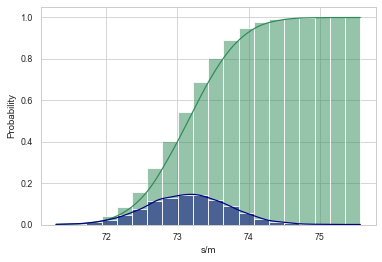

In [16]:
start = time.time()
np.random.seed(42) # Fix seed
v0 = 25/3.6
N = 20 # Number of wagons
M = 1e4 # Number of MC iterations
# Critical distances
distcrit = [59, 60, 61, 62, 63]#[38, 39, 40, 41, 42]
slist = [] # List for storage of individual distances
for k in range(int(M)):
    # Generate random data
    data = {'v0' : v0,
            'mloco': mLoco,
            'Floco': FLoco,
            'lloco': 10.5,
            'tfloco': 24,
            'Gloco': 1,
            'm' : 90000*np.ones(N), # Mass of individual wagons
            'mrot': 1.04*np.ones(N), # Dynamic augment
            'G' : np.ones(N), # G mode of individual wagon
            'Cdia': 0.406*np.ones(N), # Cylinder diameter
            'p' : np.random.normal(loc = 3.8e5, scale = 5e3, size = N),
            'l' : 14*np.ones(N),
            'i' : 5.65*np.ones(N), #4 axle, loaded
            'eta' : np.random.normal(loc = 0.83, scale = 0.02, size = N),
            'tf' : np.random.normal(loc = 24, scale = 2, size = N),
            'n' : 16*np.ones(N), # Number of brake blocks
            'muc': np.random.normal(loc = 1, scale = 0.025, size = N) # Friction correction factor
           }
    # Perform brake calculation
    s = ShuntingBrakeCalculation(data)
    # Append result to list
    slist.append(s)
elapsed = time.time()-start
# Plot histogram
sns.histplot(slist, kde = True, cumulative=True, stat = 'probability', 
             color = 'seagreen', label = 'Cumulative Density', bins = 20)
sns.histplot(slist, kde = True, stat = 'probability', 
             color = 'navy', label = 'Probability Density', bins = 20)
plt.ylabel('Probability')
plt.xlabel('s/m')
# Uncomment to save figure
plt.savefig('Class363' + str(N) + 
            'WagonsG'+str(round(v0))+
            'M' + str(M) +'.pdf')
# Print statistical values
print('Mean: ' + str(np.mean(slist)))
print('SD  : ' + str(np.std(slist)))
ssorted = np.sort(slist)
if M >= 1e7:
    print('p = 1e-5 for: ' + str(ssorted[-101]))
print('Longest: ' + str(ssorted[-1]))
# Analyse for relative frequency of braking distance above threshold
df = pd.DataFrame(columns = ['s', 'p'])
for d in distcrit:
    p, b = np.histogram(slist, bins = [0, d, 1e6])
    p = p/M
    print('p(s> ' + str(d) + 'm) = ' + str(p[1]))
    df.loc[len(df.index)] = [d, p[1]]
# Uncomment to save data
df.to_excel('Class363' + str(N) + 
            'WagonsG'+str(round(v0))+
            'M' + str(M) +'.xlsx', index=False)
print('Time: ' + str(np.round(elapsed, decimals = 2)) + ' s')
df2 = pd.DataFrame(data = slist, columns = ['s'])
# Uncomment to save data
# Save data to file
df2.to_csv('Class363' + str(N) + 
            'WagonsG'+str(round(v0))+
            'M' + str(M) +'Distances.csv')

### Comparison to UIC 544-1, App. H

The simulated braking distances are compared to those resulting from calculcation acc. to App. H, Eq. 13.

In [ ]:
lambdawagon = 65
v0 = 5/3.6
tf = 4
d = 0.0075*lambdawagon + 0.076
s = v0**2/(2*d) + v0*tf/2
print('Mean deceleration: ' + str(d) + ' m/s/s')
print('Braking distance: ' + str(s) + ' m')

In [17]:
df = pd.read_csv('Distances.csv')
slist = df.values.tolist()

In [19]:
v0 = 25/3.6
N = 5 # Number of wagons
M = 1e7 # Number of MC iterations
# Critical distances
distcrit = [38, 39, 40, 41, 42]

In [ ]:
# Plot histogram
sns.histplot(slist, kde = True, cumulative=True, stat = 'probability', 
             color = 'seagreen', label = 'Cumulative Density', bins = 20)
sns.histplot(slist, kde = True, stat = 'probability', 
             color = 'navy', label = 'Probability Density', bins = 20)
plt.ylabel('Probability')
plt.xlabel('s/m')
# Uncomment to save figure
plt.savefig('Class363' + str(N) + 
            'WagonsP'+str(round(v0))+
            'M' + str(M) +'.pdf')
# Print statistical values
print('Mean: ' + str(np.mean(slist)))
print('SD  : ' + str(np.std(slist)))
ssorted = np.sort(slist)
if M >= 1e7:
    print('p = 1e-5 for: ' + str(ssorted[-101]))
print('Longest: ' + str(ssorted[-1]))
# Analyse for relative frequency of braking distance above threshold
df = pd.DataFrame(columns = ['s', 'p'])
for d in distcrit:
    p, b = np.histogram(slist, bins = [0, d, 1e6])
    p = p/M
    print('p(s> ' + str(d) + 'm) = ' + str(p[1]))
    df.loc[len(df.index)] = [d, p[1]]
# Uncomment to save data
df.to_excel('Class363' + str(N) + 
            'WagonsP'+str(round(v0))+
            'M' + str(M) +'.xlsx', index=False)
print('Time: ' + str(np.round(elapsed, decimals = 2)) + ' s')
df2 = pd.DataFrame(data = slist, columns = ['s'])
# Uncomment to save data
# Save data to file
df2.to_csv('Class363' + str(N) + 
            'WagonsP'+str(round(v0))+
            'M' + str(M) +'Distances.csv')